# 数据清理及可视化

任务主题：论文数量统计，即统计2019年全年计算机各个方向论文数量；

任务内容：赛题的理解、使用 Pandas 读取数据并进行统计；

任务成果：学习 Pandas 的基础操作；

数据来源：https://www.kaggle.com/Cornell-University/arxiv 和 https://arxiv.org/category_taxonomy


In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具


In [2]:
with open("arxiv-metadata-oai-snapshot.json") as f:
  for line in f:
    print(line)
    break

{"id":"0704.0001","submitter":"Pavel Nadolsky","authors":"C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan","title":"Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies","comments":"37 pages, 15 figures; published version","journal-ref":"Phys.Rev.D76:013009,2007","doi":"10.1103/PhysRevD.76.013009","report-no":"ANL-HEP-PR-07-12","categories":"hep-ph","license":null,"abstract":"  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predic

In [3]:

# 读入数据
data  = []
#使用with语句优势：1.自动关闭文件句柄；2.自动显示（处理）文件读取数据异常
with open("arxiv-metadata-oai-snapshot.json", 'r') as f: 
    for idx, line in enumerate(f):         
        # 读取前100行，如果读取所有数据需要8G内存
        if idx >= 100:
            break        
        data.append(json.loads(line)) # 将已编码的 JSON 字符串解码为 Python 对象
        
data = pd.DataFrame(data) #将list变为dataframe格式，方便使用pandas进行分析
data.shape #显示数据大小

(100, 14)

In [4]:
data.head()

,abstract,authors,authors_parsed,categories,comments,doi,id,journal-ref,license,report-no,submitter,title,update_date,versions
0,A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",hep-ph,"37 pages, 15 figures; published version",10.1103/PhysRevD.76.013009,0704.0001,"Phys.Rev.D76:013009,2007",None,ANL-HEP-PR-07-12,Pavel Nadolsky,Calculation of prompt diphoton production cros...,2008-11-26,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007..."
1,"We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,"[[Streinu, Ileana, ], [Theran, Louis, ]]",math.CO cs.CG,To appear in Graphs and Combinatorics,None,0704.0002,None,http://arxiv.org/licenses/nonexclusive-distrib...,None,Louis Theran,Sparsity-certifying Graph Decompositions,2008-12-13,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200..."
2,The evolution of Earth-Moon system is descri...,Hongjun Pan,"[[Pan, Hongjun, ]]",physics.gen-ph,"23 pages, 3 figures",None,0704.0003,None,None,None,Hongjun Pan,The evolution of the Earth-Moon system based o...,2008-01-13,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007..."
3,We show that a determinant of Stirling cycle...,David Callan,"[[Callan, David, ]]",math.CO,11 pages,None,0704.0004,None,None,None,David Callan,A determinant of Stirling cycle numbers counts...,2007-05-23,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200..."
4,In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",math.CA math.FA,None,None,0704.0005,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,2013-10-15,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
abstract          100 non-null object
authors           100 non-null object
authors_parsed    100 non-null object
categories        100 non-null object
comments          87 non-null object
doi               50 non-null object
id                100 non-null object
journal-ref       52 non-null object
license           11 non-null object
report-no         8 non-null object
submitter         100 non-null object
title             100 non-null object
update_date       100 non-null object
versions          100 non-null object
dtypes: object(14)
memory usage: 11.0+ KB


In [6]:

def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
                                 'report-no', 'categories', 'license', 'abstract', 'versions',
                                 'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break   
            d = json.loads(line)
            d = {col : d[col] for col in columns} # 选取需要的数据特征
            data.append(d)
    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json', ['id', 'categories', 'update_date'])

In [7]:
data.head()

,categories,id,update_date
0,hep-ph,0704.0001,2008-11-26
1,math.CO cs.CG,0704.0002,2008-12-13
2,physics.gen-ph,0704.0003,2008-01-13
3,math.CO,0704.0004,2007-05-23
4,math.CA math.FA,0704.0005,2013-10-15


In [8]:
data["categories"].describe()

count      1796911
unique       62055
top       astro-ph
freq         86914
Name: categories, dtype: object

In [9]:
#由于部分论文的类别不止一种，所以下面判断在本数据集中共出现了多少种独立的数据集。
#set() 函数创建一个无序不重复元素集，删除重复类别，统计所有类别。
unique_categories = set([i for l in [x.split(' ') for x in data["categories"]] for i in l])
#注释 先对所有类别拆分，再是两层for循环，所有行的类别特征传给l，再将拆分后的数据分开传给i，由set()函数去重处理
print(len(unique_categories))
unique_categories

176


{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'econ.GN',
 'econ.TH',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'eess.SY',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'm

In [10]:
# unique_categories = set([i for l in [x.split(' ') for x in data["categories"]] for i in l])
#注释 先对所有类别拆分，再是两层for循环，所有行的类别特征传给l，再将拆分后的数据分开传给i，由set()函数去重处理
categories_list =[]
for l in [x.split(' ') for x in data["categories"]]:
  for i in l:
    categories_list.append(i)
unique_categories = set(categories_list)
print(len(unique_categories))
unique_categories

176


{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'econ.GN',
 'econ.TH',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'eess.SY',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'm

In [11]:
data["year"] = pd.to_datetime(data["update_date"]).dt.year #将update_date从例如2019-02-20的str变为datetime格式，并提取处year
del data["update_date"] #删除 update_date特征，其使命已完成
data = data[data["year"] >= 2019] #找出 year 中2019年以后的数据，并将其他数据删除
data.head() #查看结果

,categories,id,year
296,astro-ph,0704.0297,2019
341,math.AT,0704.0342,2019
359,astro-ph,0704.0360,2019
524,gr-qc,0704.0525,2019
534,astro-ph,0704.0535,2019


In [12]:
data.reset_index(drop=True, inplace=True) #重新编号
data

,categories,id,year
0,astro-ph,0704.0297,2019
1,math.AT,0704.0342,2019
2,astro-ph,0704.0360,2019
3,gr-qc,0704.0525,2019
4,astro-ph,0704.0535,2019
5,nucl-ex,0704.0710,2019
6,hep-th,0704.0752,2020
7,quant-ph,0704.0803,2019
8,cond-mat.stat-mech,0704.0880,2020
9,math.DG,0704.0981,2019


In [13]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags 

#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
  if t.name == "h2":
    level_1_name = t.text
    level_2_code = t.text
    level_2_name = t.text
  elif t.name == "h3":
    raw = t.text
    level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
    #level_2_code = re.match(r"(.*)\((.*)\)",raw).group(2)
    level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    #level_2_code = re.match(r"(.*)\((.*)\)",raw).group(1)
  elif t.name == "h4":
    raw = t.text
    level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
    level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
  elif t.name == "p":
    notes = t.text
    level_1_names.append(level_1_name)
    level_2_names.append(level_2_name)
    level_2_codes.append(level_2_code)
    level_3_names.append(level_3_name)
    level_3_codes.append(level_3_code)
    level_3_notes.append(notes)


#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})
#按照 "group_name" 进行分组，在组内使用 "archive_name" 进行排序
df_taxonomy.groupby(["group_name","archive_name"])
df_taxonomy

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...
5,Computer Science,Computer Science,Computer Science,Computation and Language,cs.CL,Covers natural language processing. Roughly in...
6,Computer Science,Computer Science,Computer Science,Cryptography and Security,cs.CR,Covers all areas of cryptography and security ...
7,Computer Science,Computer Science,Computer Science,Computer Vision and Pattern Recognition,cs.CV,"Covers image processing, computer vision, patt..."
8,Computer Science,Computer Science,Computer Science,Computers and Society,cs.CY,"Covers impact of computers on society, compute..."
9,Computer Science,Computer Science,Computer Science,Databases,cs.DB,"Covers database management, datamining, and da..."


In [14]:
print(df_taxonomy["group_name"].str.contains("Computer Science"))

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
       ...  
125    False
126    False
127    False
128    False
129    False
130    False
131    False
132    False
133    False
134    False
135    False
136    False
137    False
138    False
139    False
140    False
141    False
142    False
143    False
144    False
145    False
146    False
147    False
148    False
149    False
150    False
151    False
152    False
153    False
154    False
Name: group_name, Length: 155, dtype: bool


In [15]:
#提取出所有Computer Sience下的类
df_Computer_science = df_taxonomy.loc[df_taxonomy["group_name"] == "Computer Science",:]
df_Computer_science

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...
5,Computer Science,Computer Science,Computer Science,Computation and Language,cs.CL,Covers natural language processing. Roughly in...
6,Computer Science,Computer Science,Computer Science,Cryptography and Security,cs.CR,Covers all areas of cryptography and security ...
7,Computer Science,Computer Science,Computer Science,Computer Vision and Pattern Recognition,cs.CV,"Covers image processing, computer vision, patt..."
8,Computer Science,Computer Science,Computer Science,Computers and Society,cs.CY,"Covers impact of computers on society, compute..."
9,Computer Science,Computer Science,Computer Science,Databases,cs.DB,"Covers database management, datamining, and da..."


# 数据分析及可视化

In [16]:
data

,categories,id,year
0,astro-ph,0704.0297,2019
1,math.AT,0704.0342,2019
2,astro-ph,0704.0360,2019
3,gr-qc,0704.0525,2019
4,astro-ph,0704.0535,2019
5,nucl-ex,0704.0710,2019
6,hep-th,0704.0752,2020
7,quant-ph,0704.0803,2019
8,cond-mat.stat-mech,0704.0880,2020
9,math.DG,0704.0981,2019


In [17]:
data.merge(df_taxonomy, on="categories", how="left")

,categories,id,year,group_name,archive_name,archive_id,category_name,category_description
0,astro-ph,0704.0297,2019,NaN,NaN,NaN,NaN,NaN
1,math.AT,0704.0342,2019,Mathematics,Mathematics,Mathematics,Algebraic Topology,"Homotopy theory, homological algebra, algebrai..."
2,astro-ph,0704.0360,2019,NaN,NaN,NaN,NaN,NaN
3,gr-qc,0704.0525,2019,Physics,General Relativity and Quantum Cosmology,gr-qc,General Relativity and Quantum Cosmology,Description coming soon
4,astro-ph,0704.0535,2019,NaN,NaN,NaN,NaN,NaN
5,nucl-ex,0704.0710,2019,Physics,Nuclear Experiment,nucl-ex,Nuclear Experiment,Description coming soon
6,hep-th,0704.0752,2020,Physics,High Energy Physics - Theory,hep-th,High Energy Physics - Theory,Description coming soon
7,quant-ph,0704.0803,2019,Physics,Quantum Physics,quant-ph,Quantum Physics,Description coming soon
8,cond-mat.stat-mech,0704.0880,2020,Physics,Condensed Matter,cond-mat,Statistical Mechanics,"Phase transitions, thermodynamics, field theor..."
9,math.DG,0704.0981,2019,Mathematics,Mathematics,Mathematics,Differential Geometry,"Complex, contact, Riemannian, pseudo-Riemannia..."


In [18]:
data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]) ##删除 id特征 和 group_name特征 都相同的数据

,categories,id,year,group_name,archive_name,archive_id,category_name,category_description
0,astro-ph,0704.0297,2019,NaN,NaN,NaN,NaN,NaN
1,math.AT,0704.0342,2019,Mathematics,Mathematics,Mathematics,Algebraic Topology,"Homotopy theory, homological algebra, algebrai..."
2,astro-ph,0704.0360,2019,NaN,NaN,NaN,NaN,NaN
3,gr-qc,0704.0525,2019,Physics,General Relativity and Quantum Cosmology,gr-qc,General Relativity and Quantum Cosmology,Description coming soon
4,astro-ph,0704.0535,2019,NaN,NaN,NaN,NaN,NaN
5,nucl-ex,0704.0710,2019,Physics,Nuclear Experiment,nucl-ex,Nuclear Experiment,Description coming soon
6,hep-th,0704.0752,2020,Physics,High Energy Physics - Theory,hep-th,High Energy Physics - Theory,Description coming soon
7,quant-ph,0704.0803,2019,Physics,Quantum Physics,quant-ph,Quantum Physics,Description coming soon
8,cond-mat.stat-mech,0704.0880,2020,Physics,Condensed Matter,cond-mat,Statistical Mechanics,"Phase transitions, thermodynamics, field theor..."
9,math.DG,0704.0981,2019,Mathematics,Mathematics,Mathematics,Differential Geometry,"Complex, contact, Riemannian, pseudo-Riemannia..."


In [19]:
data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").describe() 
# 对数据分组 按照group_name

year                         \
                                              count         mean       std   
group_name                                                                   
Computer Science                            40067.0  2019.548581  0.497640   
Economics                                     576.0  2019.699653  0.458807   
Electrical Engineering and Systems Science   3297.0  2019.584167  0.492940   
Mathematics                                 51567.0  2019.524987  0.499380   
Physics                                     79985.0  2019.520173  0.499596   
Quantitative Biology                         1994.0  2019.555667  0.497016   
Quantitative Finance                          826.0  2019.573850  0.494816   
Statistics                                   4054.0  2019.555501  0.496971   

                                                                            \
                                               min     25%     50%     75%   
group_name                                                                   
Computer Science                            2019.0  2019.0  2020.0  2020.0   
Economics                                   2019.0  2019.0  2020.0  2020.0   
Electrical Engineering and Systems Science  2019.0  2019.0  2020.0  2020.0   
Mathematics                                 2019.0  2019.0  2020.0  2020.0   
Physics                                     2019.0  2019.0  2020.0  2020.0   
Quantitative Biology                        2019.0  2019.0  2020.0  2020.0   
Quantitative Finance                        2019.0  2019.0  2020.0  2020.0   
Statistics                                  2019.0  2019.0  2020.0  2020.0   

                                                    
                                               max  
group_name                                          
Computer Science                            2020.0  
Economics                                   2020.0  
Electrical Engineering and Systems Science  2020.0  
Mathematics                                 2020.0  
Physics                                     2020.0  
Quantitative Biology                        2020.0  
Quantitative Finance                        2020.0  
Statistics                                  2020.0

In [20]:
data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"})

,id
group_name,
Computer Science,40067
Economics,576
Electrical Engineering and Systems Science,3297
Mathematics,51567
Physics,79985
Quantitative Biology,1994
Quantitative Finance,826
Statistics,4054


In [21]:
df_merge = data.merge(df_taxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

df_merge

,group_name,id
0,Physics,79985
1,Mathematics,51567
2,Computer Science,40067
3,Statistics,4054
4,Electrical Engineering and Systems Science,3297
5,Quantitative Biology,1994
6,Quantitative Finance,826
7,Economics,576


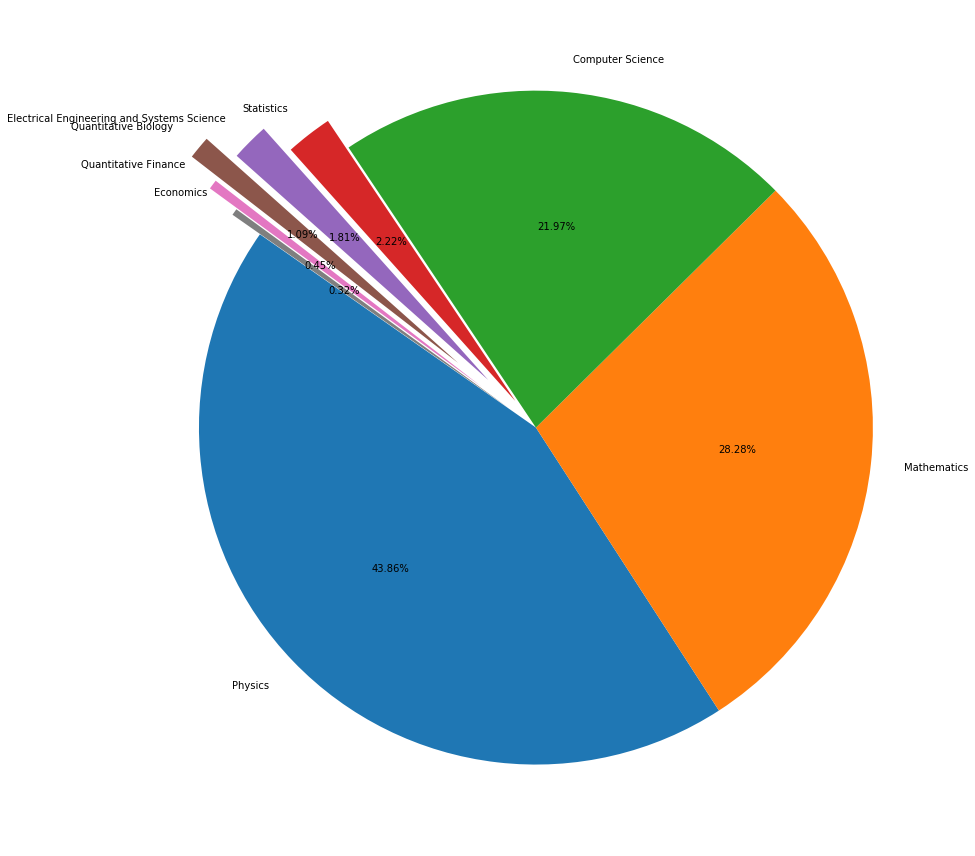

In [22]:
#下面使用饼图进行上图结果的可视化：
fig = plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.1, 0.2, 0.3, 0.2, 0.1) 
plt.pie(df_merge["id"],  labels= df_merge["group_name"], autopct='%1.2f%%', startangle=145, explode=explode)
plt.tight_layout()
plt.show()

In [23]:
group_name="Computer Science"
cats = data.merge(df_taxonomy, on="categories").query("group_name == @group_name")
cats
data1 = cats.groupby(["year","category_name"]).count().reset_index().pivot(index="category_name", columns="year",values="id")

In [24]:
data1

year,2019,2020
category_name,,
Artificial Intelligence,558,757
Computation and Language,2153,2906
Computational Complexity,131,188
"Computational Engineering, Finance, and Science",108,205
Computational Geometry,199,216
Computer Science and Game Theory,281,323
Computer Vision and Pattern Recognition,5559,6517
Computers and Society,346,564
Cryptography and Security,1067,1238


In [25]:
data1.columns

Int64Index([2019, 2020], dtype='int64', name='year')